# Haplotype Counter Analysis

This notebook demonstrates the haplotype counting functionality for analyzing ALT and REF allele support across haplotagged reads.

## Task Overview

Given:
- **BAM file**: Read alignments with haplotype tags (HP:1 or HP:2)
- **VCF file**: Phased variants (focusing on bi-allelic SNVs)

Output:
- **TSV file**: Counts of REF/ALT support for each haplotype at each SNV position


# Import required libraries

In [1]:
# Import required libraries
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import our haplotype counter functions
from haplotype_counter.haplotype_counter import (
    HaplotypeCount,
    HaplotypeCounter,
    SNV,
    export_to_tsv,
    parse_vcf_snvs
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
DEFAULT_MAX_DEPTH = 1000000

# Define Output Files

In [3]:
output_file = Path("haplotype_counts.tsv")

## Define Input Files

Let's define the paths to our test data files.


In [4]:
# Define input file paths (same as before)
data_dir = Path("test_data")
bam_file = data_dir / "giab_2023.05.hg002.haplotagged.chr16_28000000_29000000.processed.30x.bam"
vcf_file = data_dir / "giab_2023.05.hg002.wf_snp.chr16_28000000_29000000.vcf.gz"

print("File paths defined:")
print(f"   BAM: {bam_file}")
print(f"   VCF: {vcf_file}")
print(f"   Files exist: BAM={bam_file.exists()}, VCF={vcf_file.exists()}")


File paths defined:
   BAM: test_data/giab_2023.05.hg002.haplotagged.chr16_28000000_29000000.processed.30x.bam
   VCF: test_data/giab_2023.05.hg002.wf_snp.chr16_28000000_29000000.vcf.gz
   Files exist: BAM=True, VCF=True


In [5]:
assert bam_file.exists() and vcf_file.exists(), f"Input files not found {bam_file} or {vcf_file}"

# Examine total coverage in the BAM file so that we can set a max depth for the pileup

Ignore reads with the following flags:
- unmapped mates - 0x8
- unmapped - 0x4
- not primary alignment - 0x100
- read has multiple segments in the template - 0x800
- supplementary alignment - 0x1000

Combining these flags gives us 1804.

We also set the max depth to 1000000 arbitrarily.  If we notice any positions with more than 1000000x coverage, we can increase this so that we can find the true max depth.


In [6]:
# -H is to output the header
! samtools depth \
    --min-MQ 0 \
    --min-BQ 0 \
    --excl-flags 1804 \
    -d {DEFAULT_MAX_DEPTH} \
    -o coverage.txt \
    -H \
    {bam_file}

In [7]:
! head -10 coverage.txt

#CHROM	POS	test_data/giab_2023.05.hg002.haplotagged.chr16_28000000_29000000.processed.30x.bam
chr16	27971249	1
chr16	27971250	1
chr16	27971251	1
chr16	27971252	1
chr16	27971253	1
chr16	27971254	1
chr16	27971255	1
chr16	27971256	1
chr16	27971257	1


In [8]:
coverage_df = pd.read_csv("coverage.txt", sep="\t")
coverage_df.columns = ["chrom", "pos", "depth"]
coverage_df.head()


,chrom,pos,depth
0,chr16,27971249,1
1,chr16,27971250,1
2,chr16,27971251,1
3,chr16,27971252,1
4,chr16,27971253,1


We see that the max depth is < 1000000, so we can use this as our max depth.


In [9]:
coverage_df["depth"].describe()

count    1.059477e+06
mean     2.948216e+01
std      9.637833e+00
min      0.000000e+00
25%      2.400000e+01
50%      3.000000e+01
75%      3.700000e+01
max      5.100000e+01
Name: depth, dtype: float64

## Parse VCF File

First, let's parse the VCF file to extract bi-allelic SNVs.


In [10]:
# Parse SNVs from VCF file
print("Parsing VCF file for bi-allelic SNVs...")
snvs = parse_vcf_snvs(vcf_file)

print(f"Found {len(snvs)} bi-allelic SNVs")
print("\nFirst 10 SNVs:")
for i, snv in enumerate(snvs[:10]):
    print(f"{i+1:2d}. {snv.chrom}:{snv.pos_1based} {snv.ref}>{snv.alt}")

if len(snvs) > 10:
    print(f"... and {len(snvs) - 10} more")


Parsing VCF file for bi-allelic SNVs...
Found 939 bi-allelic SNVs

First 10 SNVs:
 1. chr16:28001381 G>A
 2. chr16:28002344 C>G
 3. chr16:28003018 A>G
 4. chr16:28003088 A>G
 5. chr16:28004801 T>G
 6. chr16:28005275 A>G
 7. chr16:28005283 C>T
 8. chr16:28005765 A>C
 9. chr16:28005920 A>G
10. chr16:28007874 G>A
... and 929 more


## Analyze a Single SNV

Let's analyze one SNV in detail to understand the process.


In [11]:
if snvs:
    test_snv: SNV = snvs[0]
    print(f"Analyzing SNV: {test_snv.chrom}:{test_snv.pos_1based} {test_snv.ref}>{test_snv.alt}")

    # Count allele support for this SNV
    with HaplotypeCounter(
        bam_file=bam_file,
        min_base_quality=0,
        min_mapping_quality=0,
        max_depth=1000,
        stepper='nofilter'
    ) as counter:
        count: HaplotypeCount = counter.count_single_snv(snv=test_snv)


    print(f"\nResults for {test_snv.chrom}:{test_snv.pos_1based}:")
    print(f"  Haplotype 1 - REF ({test_snv.ref}): {count.h1_ref} reads")
    print(f"  Haplotype 1 - ALT ({test_snv.alt}): {count.h1_alt} reads")
    print(f"  Haplotype 2 - REF ({test_snv.ref}): {count.h2_ref} reads")
    print(f"  Haplotype 2 - ALT ({test_snv.alt}): {count.h2_alt} reads")

    total_reads = count.h1_ref + count.h1_alt + count.h2_ref + count.h2_alt
    print(f"  Total supporting reads: {total_reads}")
else:
    print("No SNVs found to analyze")


Analyzing SNV: chr16:28001381 G>A

Results for chr16:28001381:
  Haplotype 1 - REF (G): 11 reads
  Haplotype 1 - ALT (A): 4 reads
  Haplotype 2 - REF (G): 3 reads
  Haplotype 2 - ALT (A): 12 reads
  Total supporting reads: 30


## Process All SNVs

Now let's process all SNVs in the VCF file. This may take a few minutes depending on the number of variants.


In [12]:
%%time

all_counts = []

# Process all SNVs
print("Processing all SNVs... This may take a few minutes.")
print(f"Total SNVs to process: {len(snvs)}")

with HaplotypeCounter(
    bam_file=bam_file,
    min_base_quality=0,
    min_mapping_quality=0,
    max_depth=1000,
    stepper='nofilter'
) as counter:
    all_counts: list[HaplotypeCount] = counter.process_vcf(vcf_file)

print(f"✅ Processed {len(all_counts)} SNVs successfully!")


Processing all SNVs... This may take a few minutes.
Total SNVs to process: 939
✅ Processed 939 SNVs successfully!
CPU times: user 25 s, sys: 893 ms, total: 25.9 s
Wall time: 27.2 s


## Export Results

Let's export our results to a TSV file as required by the task.


In [13]:
# Export to TSV fils
export_to_tsv(counts=all_counts, output_file=output_file)

print(f"Results exported to {output_file}")
print(f"File size: {output_file.stat().st_size / 1024:.1f} KB")

# Show the first few lines of the output file
print("\nFirst 10 lines of output TSV:")
with open(output_file) as f:
    for i, line in enumerate(f):
        if i >= 10:
            break
        print(f"{i+1:2d}: {line.strip()}")




Results exported to haplotype_counts.tsv
File size: 22.3 KB

First 10 lines of output TSV:
 1: chrom	pos	h1_REF	h1_ALT	h2_REF	h2_ALT
 2: chr16	28001381	11	4	3	12
 3: chr16	28002344	11	5	3	12
 4: chr16	28003018	12	4	3	13
 5: chr16	28003088	12	4	3	11
 6: chr16	28004801	13	4	3	9
 7: chr16	28005275	12	4	3	10
 8: chr16	28005283	11	4	2	10
 9: chr16	28005765	11	4	6	7
10: chr16	28005920	12	4	4	10


# Summary Stats

/usr/local/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

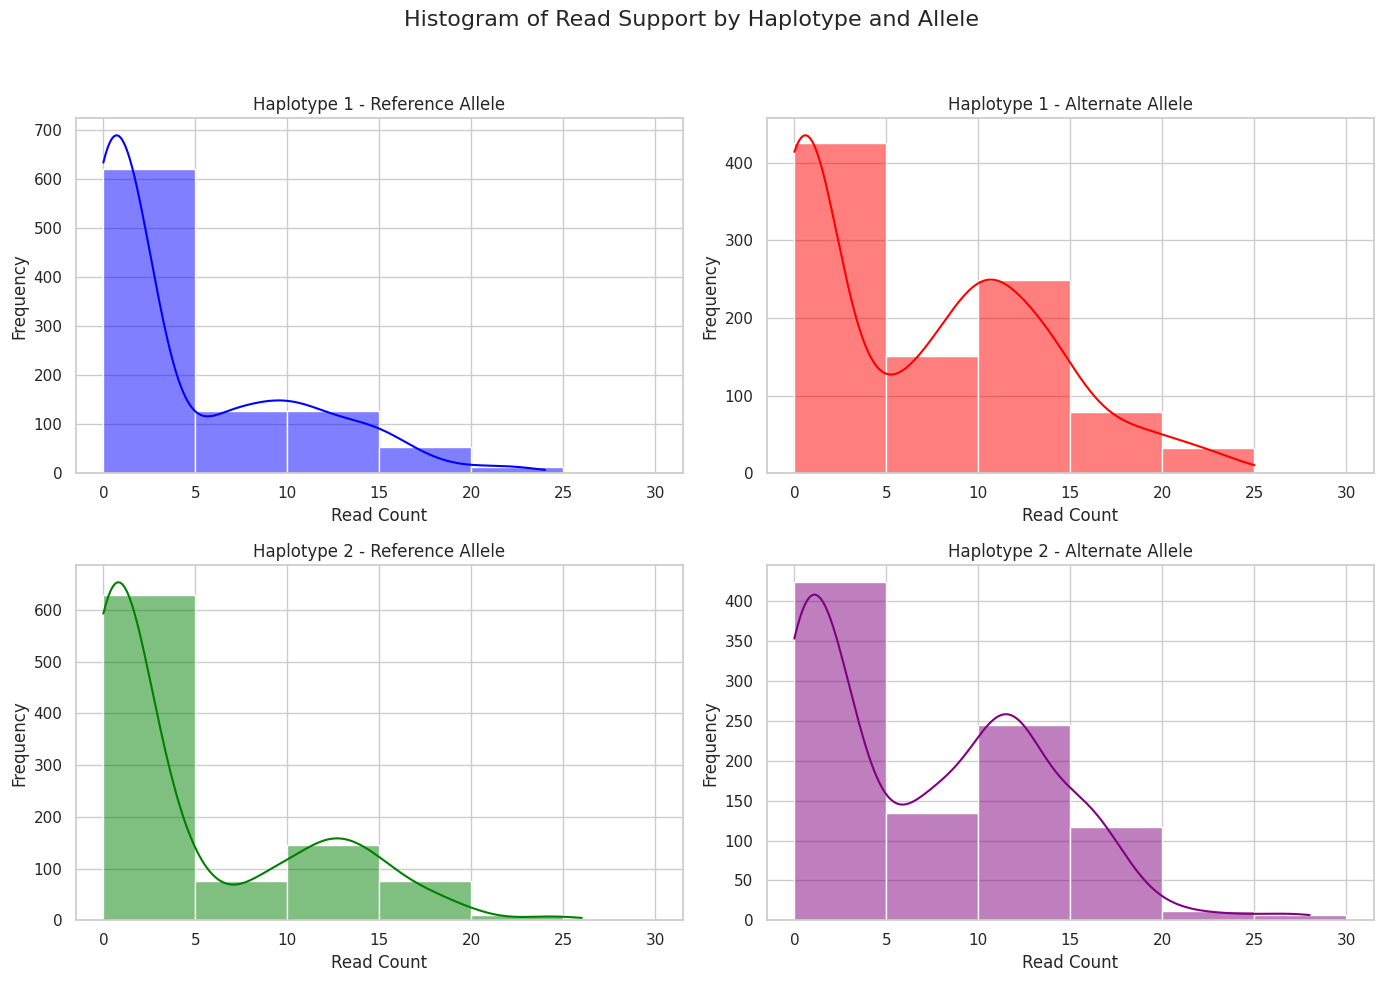

<Figure size 1200x600 with 0 Axes>

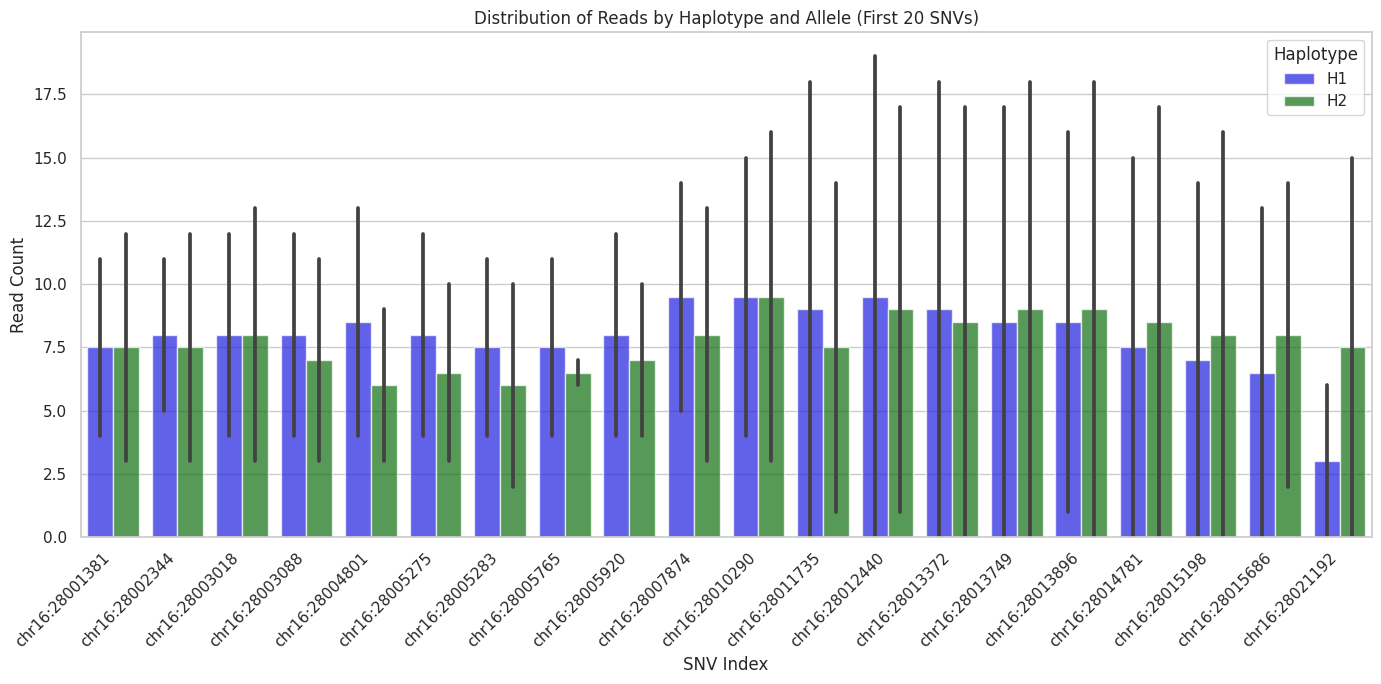


Summary Statistics:
H1 Reference: Mean=4.45, Median=2.00, Max=24
H1 Alternate: Mean=6.94, Median=7.00, Max=25
H2 Reference: Mean=4.83, Median=2.00, Max=26
H2 Alternate: Mean=7.23, Median=7.00, Max=28


In [14]:
# Create a histogram of total support stratified by h1_ref, h1_alt, h2_ref, h2_alt
# Set the seaborn style
sns.set_theme(style="whitegrid")

# Convert the counts to a DataFrame for easier manipulation
data = []
for count in all_counts:
    data.append({
        'h1_ref': count.h1_ref,
        'h1_alt': count.h1_alt,
        'h2_ref': count.h2_ref,
        'h2_alt': count.h2_alt,
        'position': f"{count.chrom}:{count.pos_1based}"
    })

df = pd.DataFrame(data)

# Calculate total support for each category
df['h1_total'] = df['h1_ref'] + df['h1_alt']
df['h2_total'] = df['h2_ref'] + df['h2_alt']

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Histogram of Read Support by Haplotype and Allele', fontsize=16)

# Plot histograms using seaborn
bins = np.arange(0, max(df['h1_ref'].max(), df['h1_alt'].max(), df['h2_ref'].max(), df['h2_alt'].max()) + 5, 5)

sns.histplot(df['h1_ref'], bins=bins, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Haplotype 1 - Reference Allele')
axes[0, 0].set_xlabel('Read Count')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df['h1_alt'], bins=bins, kde=True, color='red', ax=axes[0, 1])
axes[0, 1].set_title('Haplotype 1 - Alternate Allele')
axes[0, 1].set_xlabel('Read Count')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(df['h2_ref'], bins=bins, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Haplotype 2 - Reference Allele')
axes[1, 0].set_xlabel('Read Count')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df['h2_alt'], bins=bins, kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('Haplotype 2 - Alternate Allele')
axes[1, 1].set_xlabel('Read Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Also create a stacked bar chart showing the distribution of reads across all SNVs
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(min(20, len(df)))  # Show at most 20 SNVs for clarity

# Select a subset of SNVs for visualization
subset_df = df.iloc[:min(20, len(df))]

# Reshape data for seaborn
plot_data = []
for i, row in subset_df.iterrows():
    plot_data.append({'SNV': i, 'Haplotype': 'H1', 'Allele': 'Ref', 'Count': row['h1_ref']})
    plot_data.append({'SNV': i, 'Haplotype': 'H1', 'Allele': 'Alt', 'Count': row['h1_alt']})
    plot_data.append({'SNV': i, 'Haplotype': 'H2', 'Allele': 'Ref', 'Count': row['h2_ref']})
    plot_data.append({'SNV': i, 'Haplotype': 'H2', 'Allele': 'Alt', 'Count': row['h2_alt']})

plot_df = pd.DataFrame(plot_data)

# Create a grouped bar chart with seaborn
plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x='SNV',
    y='Count',
    hue='Haplotype',
    palette={'H1': 'blue', 'H2': 'green'},
    alpha=0.7
)

plt.xlabel('SNV Index')
plt.ylabel('Read Count')
plt.title('Distribution of Reads by Haplotype and Allele (First 20 SNVs)')
plt.xticks(range(min(20, len(df))), subset_df['position'], rotation=45, ha='right')
plt.legend(title='Haplotype')
plt.tight_layout()
plt.show()

# Print summary statistics for each category
print("\nSummary Statistics:")
print(f"H1 Reference: Mean={df['h1_ref'].mean():.2f}, Median={df['h1_ref'].median():.2f}, Max={df['h1_ref'].max()}")
print(f"H1 Alternate: Mean={df['h1_alt'].mean():.2f}, Median={df['h1_alt'].median():.2f}, Max={df['h1_alt'].max()}")
print(f"H2 Reference: Mean={df['h2_ref'].mean():.2f}, Median={df['h2_ref'].median():.2f}, Max={df['h2_ref'].max()}")
print(f"H2 Alternate: Mean={df['h2_alt'].mean():.2f}, Median={df['h2_alt'].median():.2f}, Max={df['h2_alt'].max()}")
